# Trabalho Prático 2 - Implementação do Algoritmo de Boosting

- **Aluno:** Vítor Gabriel Reis Caitité
- **Matrícula:** 2021712430

In [61]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline
import seaborn as sns
import tabulate

## Leitura e Pré-processamento dos Dados

In [62]:
names = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'class']
df = pd.read_csv('data/tic-tac-toe.data', header=None, sep=',', names=names)
df.head()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,class
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [63]:
# Encode categorical label as numbers
df['class'] = df['class'].replace({'negative': -1, 'positive': 1})
y = df[['class']].to_numpy()
y = y.flatten()
# One-hot encode board space columns
X = df.drop('class', axis=1)
one_hot_encoder = OneHotEncoder()
X = one_hot_encoder.fit_transform(X).toarray()

## Implementação do Algoritmo de Boosting

In [76]:
from sklearn.base import BaseEstimator, ClassifierMixin
class AdaBoost(BaseEstimator, ClassifierMixin):
    
    def __init__(self, n_estimators=100):
        self.n_estimators = n_estimators # number of estimators
        self.estimators = []            # list of estimators               
        self.alpha = []                  # list of weights relation with each weak classifier
    
    
    # Function to fit the model. Arguments:
    # X: independent variables - numpy array (n_samples x n_features)
    # y: target variable - numpy array (targets must be -1 or 1)
    def fit(self, X, y):
        # Step 1. Initialize all the observation weights (wi) with 1/(number_of_samples):
        self.w = np.ones([len(y)])/ len(y) 
                
        # Step 2: Iterate over the estimators:
        for estimator in range(self.n_estimators):
            # 2.a: Fit a estimator with the training data using the weights w:
            estimator = DecisionTreeClassifier(max_depth=1)
            estimator.fit(X, y, sample_weight=self.w)
            self.estimators.append(estimator) # saving on the list of wek classifiers
    
            # 2.b: Compute the error:
            y_hat = estimator.predict(X)
            error = 0
            for idx in range(len(y)):
                error += (self.w[idx] * abs(y_hat[idx] - y[idx])/2)
                        
            # 2.c: Compute alpha_i:
            self.alpha.append(0.5 * np.log((1 - error)/error))
                        
            # 2.d: Update weights w:
            self.w =  self.w * np.exp(-self.alpha[-1] * y_hat * y)/sum(self.w)
    
    # Function to predict. Arguments:
    # X: independent variables - numpy array (n_samples x n_features)
    def predict(self, X): 
        predictions = np.zeros([X.shape[0], self.n_estimators])
         # Predict class label for each weak classifier (weighted by alpha[i])
        for idx, classifier in enumerate(self.estimators):
            predictions[:, idx] = classifier.predict(X) * self.alpha[idx]
        # Final predictions:
        y_hat = np.zeros(X.shape[0])
        for idx in range(X.shape[0]):
            y_hat[idx] = (1 * np.sign(predictions[idx, :].sum())).astype(int)
        y_hat[y_hat==0] = 1 
        return y_hat

## Validação do Modelo (5-fold cross-validation) 

In [77]:
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):
    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    plt.figure(figsize=(7,4))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="BuPu", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
    plt.show()

In [78]:
def plot_grid_search(cv_results, grid_param_1, name_param_1):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean)
    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd)

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)
    ax.errorbar(grid_param_1, scores_mean, scores_sd, color = 'blue', marker='s', capsize=5)

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.grid('on')
    

In [93]:
def apply_cross_validation(model, params={}, random_state=None):
    k_fold = KFold(n_splits=5, shuffle=True, random_state=random_state)
    predicted_classes = []
    real_classes = []
    accuracy = np.zeros(5)
    precision = np.zeros(5)
    recall = np.zeros(5)
    idx = 0
    for train_indices, test_indices in k_fold.split(X, y):
        X_train = X[train_indices]
        X_test = X[test_indices]
        y_train = y[train_indices]
        y_test = y[test_indices]
        
        # Fitting and Validating the model
        clf = model(**params)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        predicted_classes = np.append(predicted_classes, y_pred)
        real_classes = np.append(real_classes, y_test)
        
        # Calculating accuracy, precision and reall
        precision[idx] = precision_score(y_test, y_pred)
        recall[idx] = recall_score(y_test, y_pred)
        accuracy[idx] = accuracy_score(y_test, y_pred)
        idx +=1
        print(f'Accuracy (fold {idx}): ' + '{:.4f}'.format(accuracy_score(y_test, y_pred)))  
        
    mean_accuracy = '{:.4f}'.format(accuracy.mean()) + "+/-" + '{:.4f}'.format(accuracy.std())
    mean_precision ='{:.4f}'.format(precision.mean()) + "+/-" + '{:.4f}'.format(precision.std())
    mean_recall = '{:.4f}'.format(recall.mean()) + "+/-" + '{:.4f}'.format(recall.std())
    print(f"\nMean Accuracy: " + mean_accuracy) 
    print(f"Mean Precision: " + mean_precision) 
    print(f"Mean Recall: " + mean_recall) 
    plot_confusion_matrix(real_classes, predicted_classes, [-1, 1])
    return clf, mean_accuracy, mean_precision, mean_recall

Fitting 5 folds for each of 50 candidates, totalling 250 fits
The best mean accuracy was 0.9707 and was achieved for n_estimators = 270


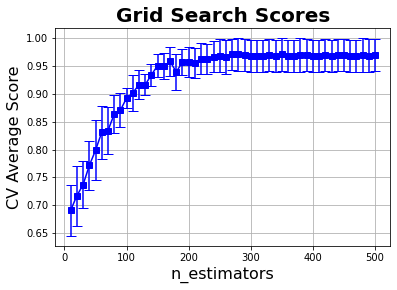

In [98]:
lst =  list(np.linspace(10, 500, 50, dtype=int))
# Grid Search application
# The max depth will be the value encountered in Decision Tree test
grid_params_gradient_boosting = [{'n_estimators': lst}]
ab = AdaBoost()
clf = GridSearchCV(ab, grid_params_gradient_boosting, scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
# Results of Grid Search
n_estimators  = clf.best_params_['n_estimators']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for n_estimators = " + str(n_estimators) )
plot_grid_search(clf.cv_results_, lst, 'n_estimators')

Accuracy (fold 1): 0.8958
Accuracy (fold 2): 0.9062
Accuracy (fold 3): 0.9219
Accuracy (fold 4): 0.9215
Accuracy (fold 5): 0.9215

Mean Accuracy: 0.9134+/-0.0106
Mean Precision: 0.8932+/-0.0214
Mean Recall: 0.9858+/-0.0126


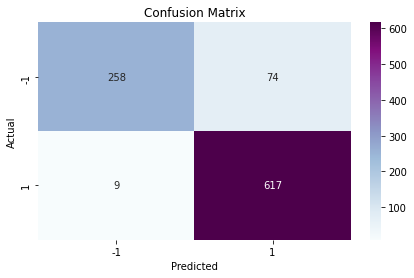

In [100]:
# Calling Method 
model =  AdaBoost
params = {'n_estimator': n_estimators}
clf, mean_accuracy_nb, mean_precision_nb, mean_recall_nb = apply_cross_validation(model)

Accuracy (fold 1): 0.8490
Accuracy (fold 2): 0.7760
Accuracy (fold 3): 0.8750
Accuracy (fold 4): 0.8220
Accuracy (fold 5): 0.8272

Mean Accuracy: 0.8298+/-0.0328
Mean Precision: 0.8185+/-0.0318
Mean Recall: 0.9499+/-0.0239


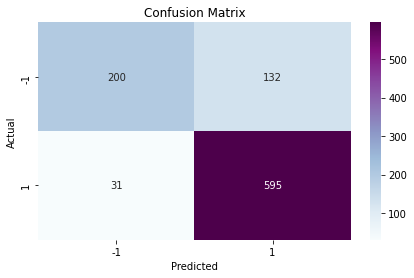

In [101]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier
params = {'n_estimator': n_estimators}
clf, mean_accuracy_nb, mean_precision_nb, mean_recall_nb = apply_cross_validation(model)

## SVM

Accuracy (fold 1): 1.0000
Accuracy (fold 2): 1.0000
Accuracy (fold 3): 1.0000
Accuracy (fold 4): 0.9634
Accuracy (fold 5): 0.9948

Mean Accuracy: 0.9916+/-0.0143
Mean Precision: 0.9952+/-0.0065
Mean Recall: 0.9921+/-0.0157


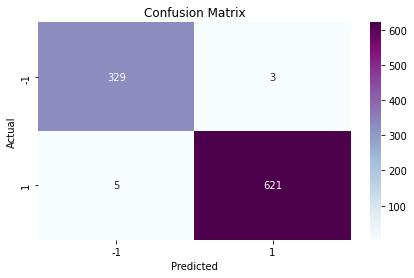

In [30]:
model = svm.SVC
params = {'kernel' : "rbf", 'gamma' : 'scale', 'C' : 10}
clf, mean_accuracy_sigmoid_svm, mean_precision_sigmoid_svm, mean_recall_sigmoid_svm = apply_cross_validation(model, params)

## Gradient Boosting

In [85]:
lst =  [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
# Grid Search application
# The max depth will be the value encountered in Decision Tree test
grid_params_gradient_boosting = [{'GradientBoosting__n_estimators': lst}]
pipe_gradient_boosting = Pipeline([('scaler',  MinMaxScaler()),
            ('GradientBoosting', GradientBoostingClassifier(max_depth = 6))])
clf = GridSearchCV(pipe_gradient_boosting, grid_params_gradient_boosting, scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
# Results of Grid Search
n_estimators  = clf.best_params_['GradientBoosting__n_estimators']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for n_estimators = " + str(n_estimators) )

Fitting 5 folds for each of 16 candidates, totalling 80 fits
The best mean accuracy was 0.8613 and was achieved for n_estimators = 130


Accuracy (fold 1): 0.9896
Accuracy (fold 2): 0.9896
Accuracy (fold 3): 1.0000
Accuracy (fold 4): 0.9895
Accuracy (fold 5): 0.9948

Mean Accuracy: 0.9927+/-0.0042
Mean Precision: 0.9904+/-0.0059
Mean Recall: 0.9984+/-0.0032


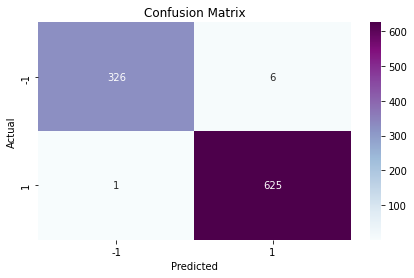

In [86]:
model = GradientBoostingClassifier
params = {'n_estimators' : n_estimators, "max_depth" : 6}
clf, mean_accuracy_gb, mean_precision_gb, mean_recall_gb = apply_cross_validation(model, params)